In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

2024-09-09 10:52:35.099821: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 10:52:35.106508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 10:52:35.114488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 10:52:35.116861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 10:52:35.122834: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1725859360.620773 1096659 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725859360.654405 1096659 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725859360.660784 1096659 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [54]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/idrone2/Desktop/chest_xray",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5121 files belonging to 4 classes.


In [55]:
class_names = dataset.class_names
class_names

['Alzheimer MildDemented',
 'Alzheimer ModerateDemented',
 'Alzheimer NonDemented',
 'Alzheimer VeryMildDemented']

Full dataset class counts: {'Alzheimer MildDemented': 717, 'Alzheimer ModerateDemented': 52, 'Alzheimer NonDemented': 2560, 'Alzheimer VeryMildDemented': 1792}


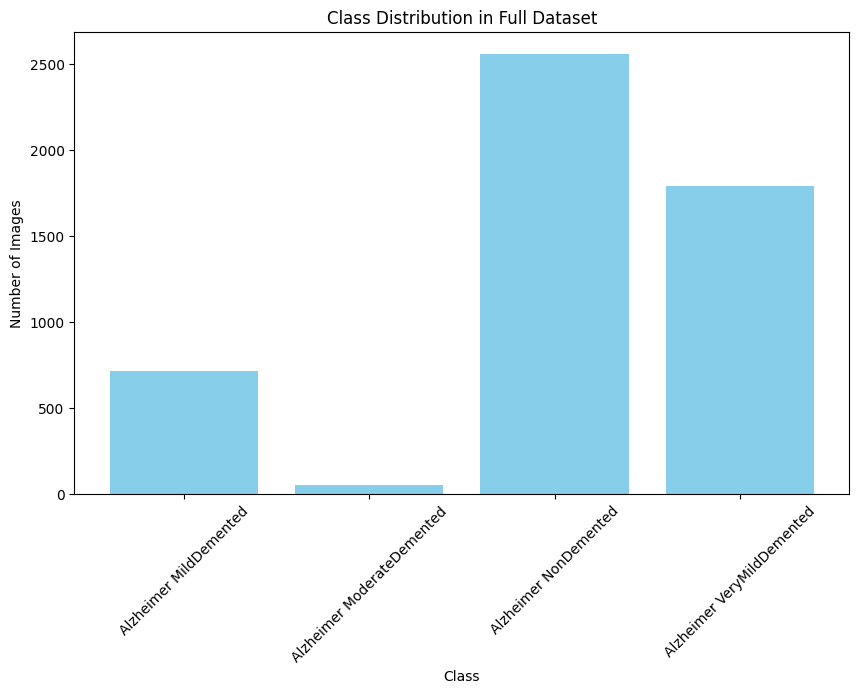

In [56]:
# Function to count images per class
def count_images_per_class(dataset):
    class_counts = {class_name: 0 for class_name in class_names}
    for images, labels in dataset:
        for label in labels.numpy():
            class_counts[class_names[int(label)]] += 1
    return class_counts

# Count images per class in the full dataset
full_class_counts = count_images_per_class(dataset)
print("Full dataset class counts:", full_class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(full_class_counts.keys(), full_class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Full Dataset')
plt.xticks(rotation=45)
plt.show()

In [57]:
# Function to split dataset
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = sum([len(batch[0]) for batch in dataset])  # Sum of all batches
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    dataset = dataset.shuffle(buffer_size=ds_size, seed=123)
    train_ds = dataset.take(train_size // BATCH_SIZE)
    val_ds = dataset.skip(train_size // BATCH_SIZE).take(val_size // BATCH_SIZE)
    test_ds = dataset.skip((train_size + val_size) // BATCH_SIZE)
    
    return train_ds, val_ds, test_ds

In [58]:
# Split the dataset
train_ds, val_ds, test_ds = split_dataset(dataset)

In [59]:
# Caching and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [60]:
# Count images per class in the train, validation, and test datasets
train_class_counts = count_images_per_class(train_ds)
val_class_counts = count_images_per_class(val_ds)
test_class_counts = count_images_per_class(test_ds)

In [61]:
print("Training dataset class counts:", train_class_counts)
print("Validation dataset class counts:", val_class_counts)
print("Test dataset class counts:", test_class_counts)

Training dataset class counts: {'Alzheimer MildDemented': 568, 'Alzheimer ModerateDemented': 40, 'Alzheimer NonDemented': 2019, 'Alzheimer VeryMildDemented': 1438}
Validation dataset class counts: {'Alzheimer MildDemented': 65, 'Alzheimer ModerateDemented': 5, 'Alzheimer NonDemented': 260, 'Alzheimer VeryMildDemented': 182}
Test dataset class counts: {'Alzheimer MildDemented': 82, 'Alzheimer ModerateDemented': 2, 'Alzheimer NonDemented': 281, 'Alzheimer VeryMildDemented': 179}


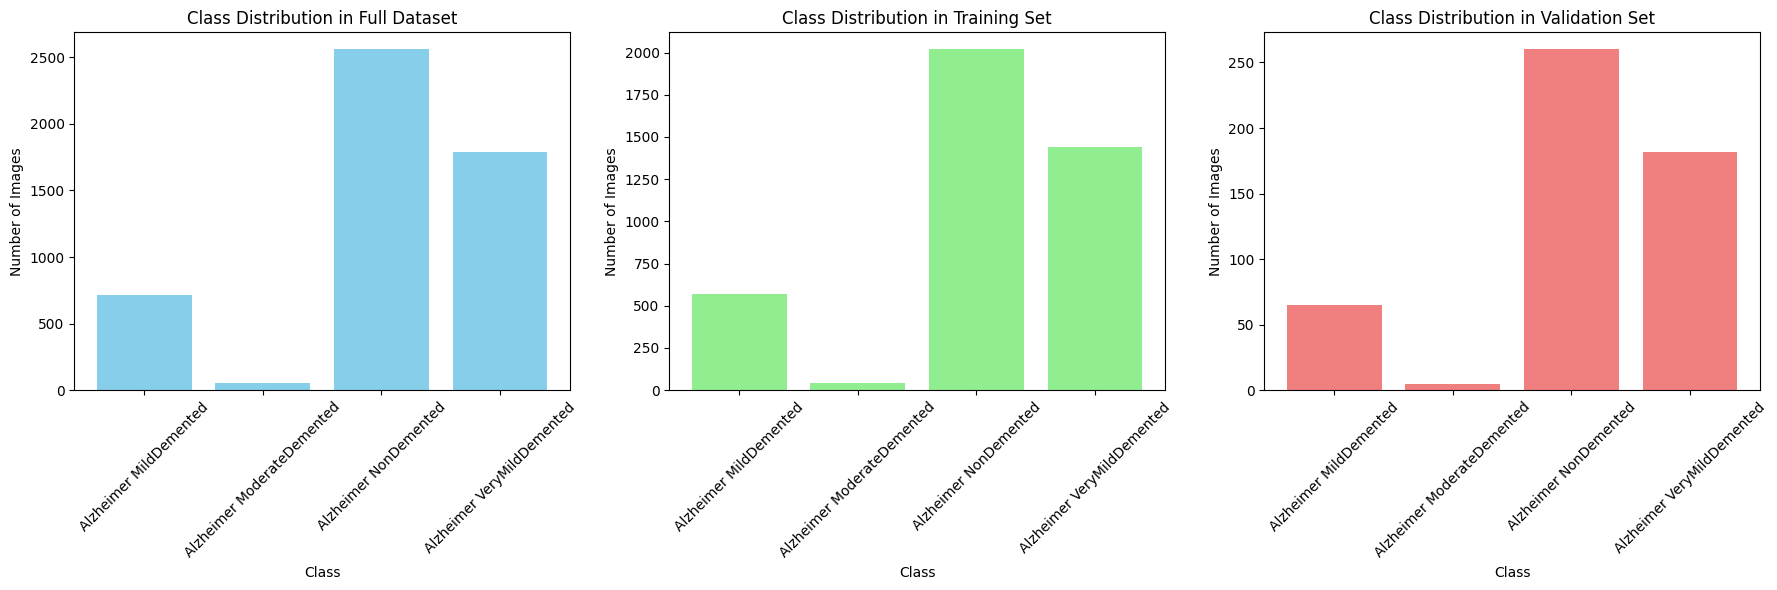

In [62]:
# Visualize class distribution after splitting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(full_class_counts.keys(), full_class_counts.values(), color='skyblue')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Class Distribution in Full Dataset')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(train_class_counts.keys(), train_class_counts.values(), color='lightgreen')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Class Distribution in Training Set')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(val_class_counts.keys(), val_class_counts.values(), color='lightcoral')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Number of Images')
axes[2].set_title('Class Distribution in Validation Set')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [24]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 0 2 2 3 2 3 2 3 0 2 2 3 0 0 0 3 2 2 2 2 2 2 2 0 3 3 0 2 2 2]


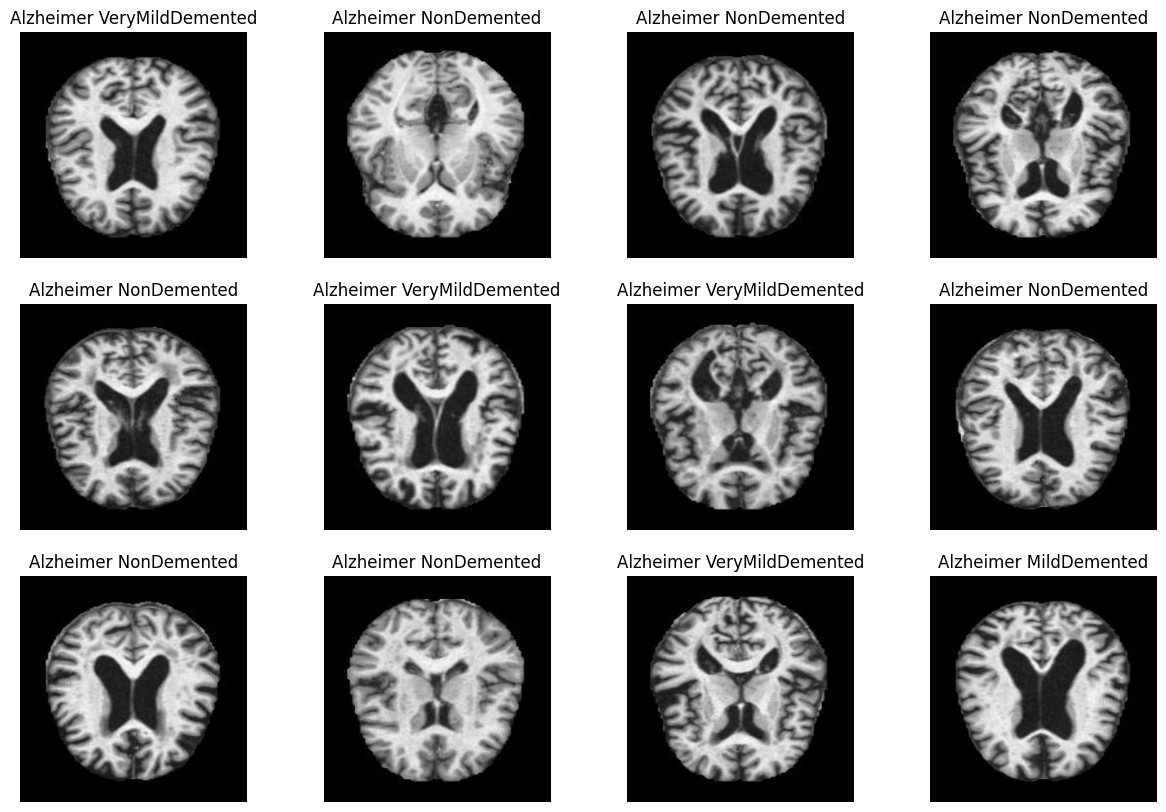

In [63]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [64]:
len(train_ds)
len(val_ds)
len(test_ds)

17

In [65]:
# Data augmentation and normalization
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
])

In [66]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [67]:
train_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(data_augmentation(x, training=True)), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [70]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

#model.build(input_shape=input_shape)


In [71]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,956 (1.06 MB)

 Trainable params: 277,956 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [73]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.4512 - loss: 1.1018 - val_accuracy: 0.5078 - val_loss: 86.5801
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.4736 - loss: 1.0456 - val_accuracy: 0.5078 - val_loss: 74.6289
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5137 - loss: 0.9977 - val_accuracy: 0.5078 - val_loss: 276.4353
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.5244 - loss: 0.9575 - val_accuracy: 0.5078 - val_loss: 229.5628
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.5550 - loss: 0.9137 - val_accuracy: 0.5078 - val_loss: 342.2430
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5365 - loss: 0.9182 - val_accuracy: 0.5078 - val_loss: 282.6005
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5399 - loss: 0.9201 - val_accuracy: 0.5078 - val_loss: 212.6596
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accura

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

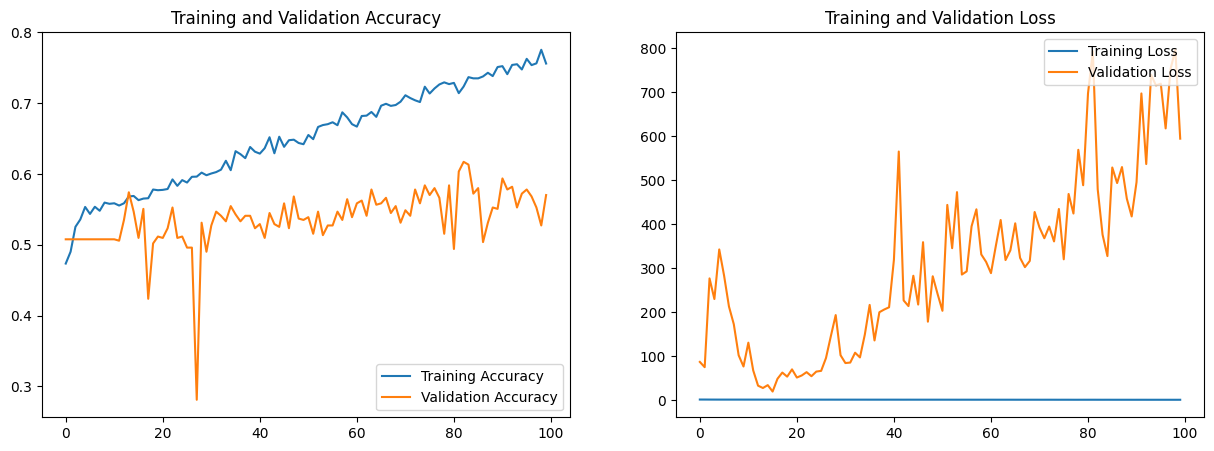

In [75]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-09-03 12:10:38.510833: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


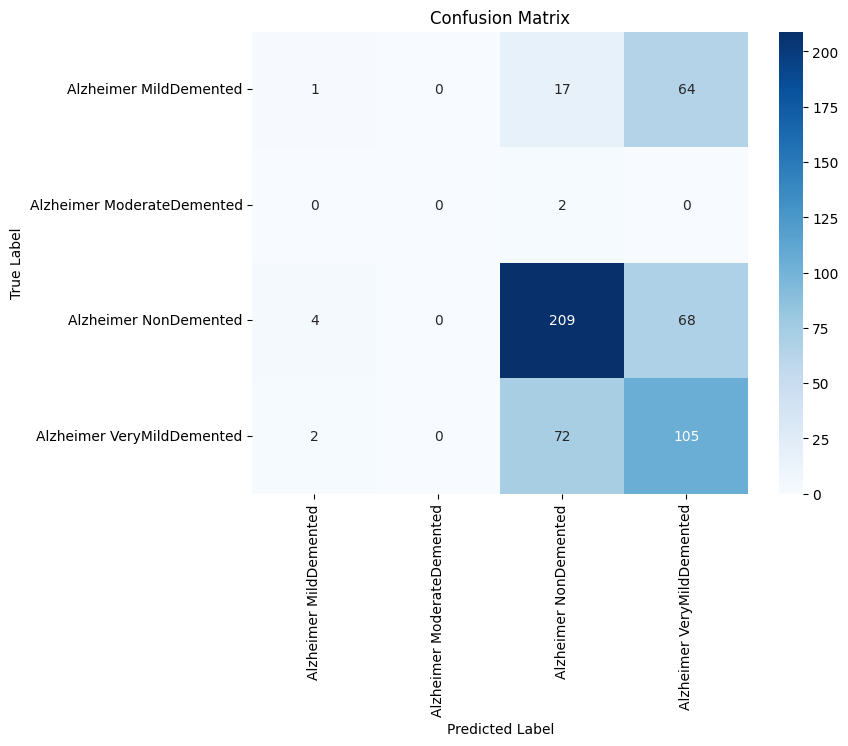

In [77]:
# Get the true labels and the predicted labels
true_labels = []
pred_labels = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [78]:
# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                             precision    recall  f1-score   support

    Alzheimer MildDemented       0.14      0.01      0.02        82
Alzheimer ModerateDemented       0.00      0.00      0.00         2
     Alzheimer NonDemented       0.70      0.74      0.72       281
Alzheimer VeryMildDemented       0.44      0.59      0.50       179

                  accuracy                           0.58       544
                 macro avg       0.32      0.34      0.31       544
              weighted avg       0.53      0.58      0.54       544



/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


first image to predict
actual label: Alzheimer NonDemented
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted label: Alzheimer NonDemented


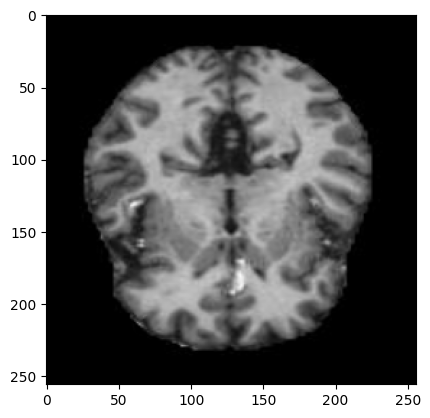

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


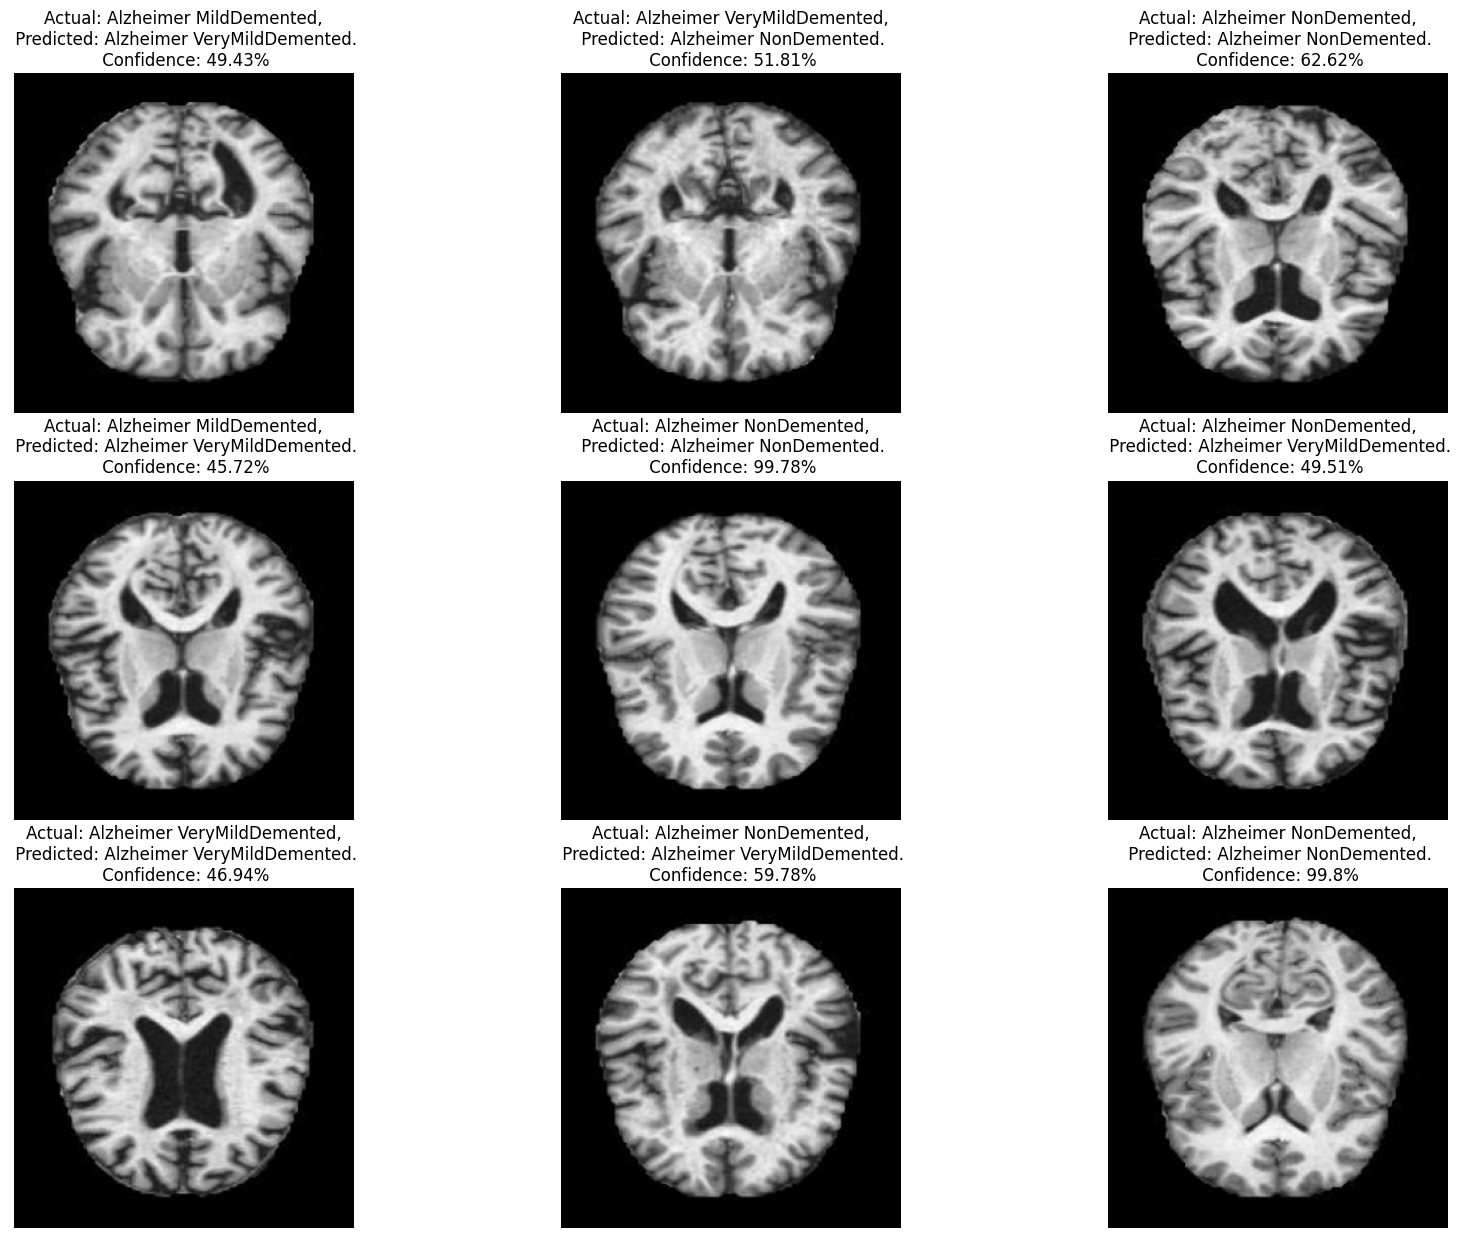

In [47]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")


In [36]:
model.save("../mri-pet.h5")

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
